# Population attack

Here we will perform a simple population attack to get an idea how much
data might be leaked.
This is much less accurate than the reference attack, but still gives a good
idea whether some of the data can be leaked.

Loading diabetes dataset
Baseline: 0.64
Our test-score: 0.75


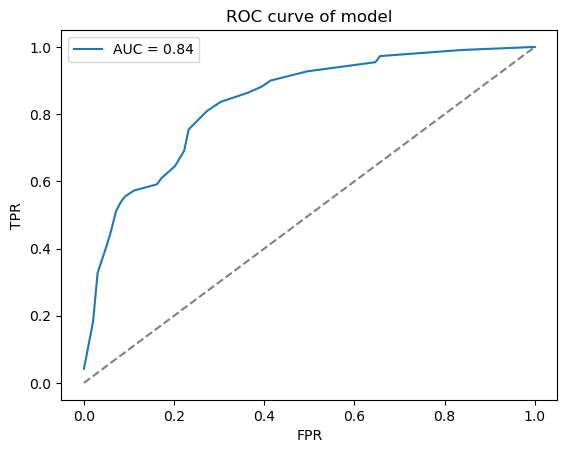

In [8]:
%run ml_load_data.ipynb

## Measuring Population-Wise Privacy Leakage

In [27]:
def logit_scale(y_true, y_pred, eps=1e-16):
    """
    Logit scaling from https://arxiv.org/abs/2112.03570
    """
    if isinstance(y_true, np.integer):
        y_true = [y_true] * len(y_pred)
        
    result = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for i in range(len(y_true)):
        y = y_true[i]
        pred = y_pred[i, y]
        result.append(
            np.log(np.clip(pred / np.clip(1 - pred, eps, np.inf), eps, np.inf))
        )
    return np.array(result)

In [28]:
def logits(target_model, X_true, y_true):
    y_pred = target_model.predict_proba(X_true)
    return logit_scale(y_true, y_pred)

In [29]:
# Extract the features for the membership inference attack.
#preds_train = target_model.predict_proba(X_train)
#preds_test = target_model.predict_proba(X_test)

logits_train = logits(target_model, X_train, y_train)
logits_test = logits(target_model, X_test, y_test)

In [30]:
def visualize_vals(train_vals, test_vals):
    """Visualize feature values on train and test data."""
    return sns.displot(
        data=pd.concat([
                pd.DataFrame(dict(val=train_vals)).assign(membership="train"),
                pd.DataFrame(dict(val=test_vals)).assign(membership="test"),
        ]),
        x="val",
        hue="membership",
        kind="hist",
        stat="probability",
        rug=True,
        common_norm=False
   ).set(title="Feature values for train and test")

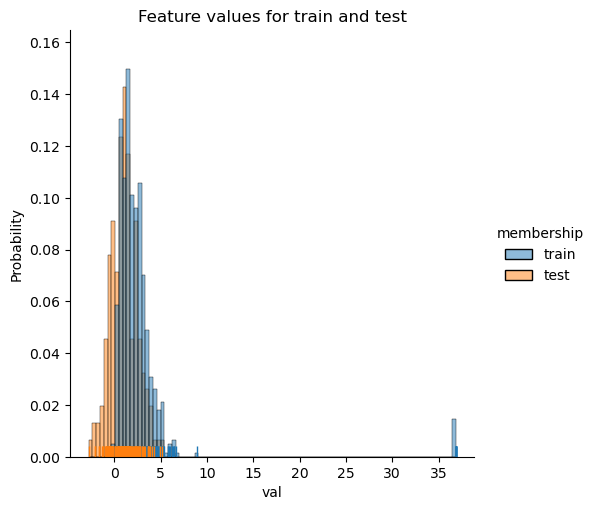

In [31]:
# Visualize the features. If it is possible to tell train data from test data, then
# our model is vulnerable to membership inference.
visualize_vals(logits_train, logits_test)

### ROC curve of the membership attack

[Text(0.5, 1.0, 'ROC of population attack')]

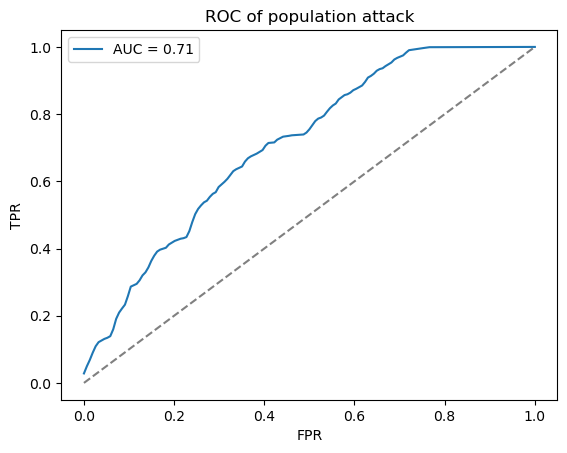

In [32]:
# Use roc_curve from scikit-learn.
membership_labels = np.concatenate([[1] * len(logits_train), [0] * len(logits_test)])

fpr, tpr, _ = roc_curve(membership_labels, np.concatenate([logits_train, logits_test]))
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--').set(title="ROC of population attack")